# Cirq device models

In order to explore what is feasible on cirq devices, you can now use tangelo to explore the types of errors one might expect when using particular cirq devices.

In [1]:
import cirq
import cirq_google
import qsimcirq
import matplotlib.pyplot as plt
import time

In [2]:
from tangelo.linq import Circuit, Gate, Simulator
from tangelo.linq.target import Cirq_QVM

Below is an example for `"weber"`. Only `"rainbow"` and `"weber"` are currently supported.

In [3]:
# Construct Quantum circuit
gates = [Gate('H', 0), Gate('CNOT', 0, 1), Gate('CNOT', 1, 2)]
circuit = Circuit(gates)

sim_ideal = Simulator('cirq', n_shots=100)
sim_weber = Simulator(Cirq_QVM, n_shots=100, noise_model="weber",
                      qubits_to_use=[cirq.GridQubit(3, 6), cirq.GridQubit(3, 4), cirq.GridQubit(3, 5)])




We can look at the device layout to select qubits by

In [4]:
print(sim_weber.sim_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                                    (2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                                    │        │        │        │        │
                                    │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

Now we can select qubits. For cirq_QVM, we need to select the qubits.

In [5]:
freqs_ideal, _ = sim_ideal.simulate(circuit)
sim_weber.qubits_to_use = [cirq.GridQubit(3, 6), cirq.GridQubit(4, 6), cirq.GridQubit(5, 6)]
freqs_weber, _ = sim_weber.simulate(circuit)

print(freqs_ideal)
print(freqs_weber)

{'000': 0.5, '100': 0.5}
{'000': 0.42, '100': 0.54, '110': 0.02, '010': 0.02}


## Choosing Qubits
Some qubits on the device have better properties. To show this, we can examine the data using the following commands

In [6]:
processor_id = "weber"
cal = cirq_google.engine.load_median_device_calibration(processor_id)
noise_props = cirq_google.noise_properties_from_calibration(cal)

One qubit error data: gate_pauli_errors
Supported Gates: {<class 'cirq.ops.common_gates.ZPowGate'>, <class 'cirq.ops.phased_x_z_gate.PhasedXZGate'>, <class 'cirq.ops.common_channels.ResetChannel'>, <class 'cirq.ops.measurement_gate.MeasurementGate'>}


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_91405/4195693688.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


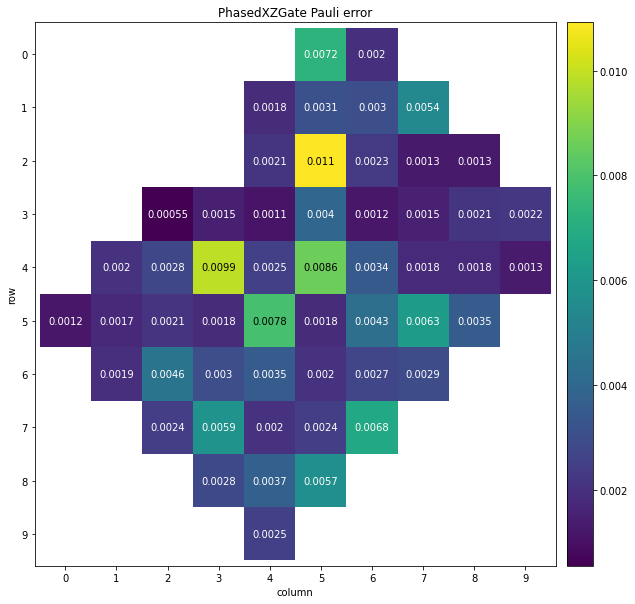

In [7]:
print(f"One qubit error data: gate_pauli_errors")
print(f"Supported Gates: {noise_props.single_qubit_gates()}")
fig, ax = plt.subplots(figsize=(10, 10))
gate = cirq.PhasedXZGate
measures = {
    op_id.qubits: pauli_error
    for op_id, pauli_error in noise_props.gate_pauli_errors.items()
    if op_id.gate_type == gate
}
ax.set_title(f"{gate.__name__} Pauli error")
_ = cirq.Heatmap(measures).plot(ax)
fig.show()

Two qubit error data: gate_pauli_errors


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_91405/2258833822.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


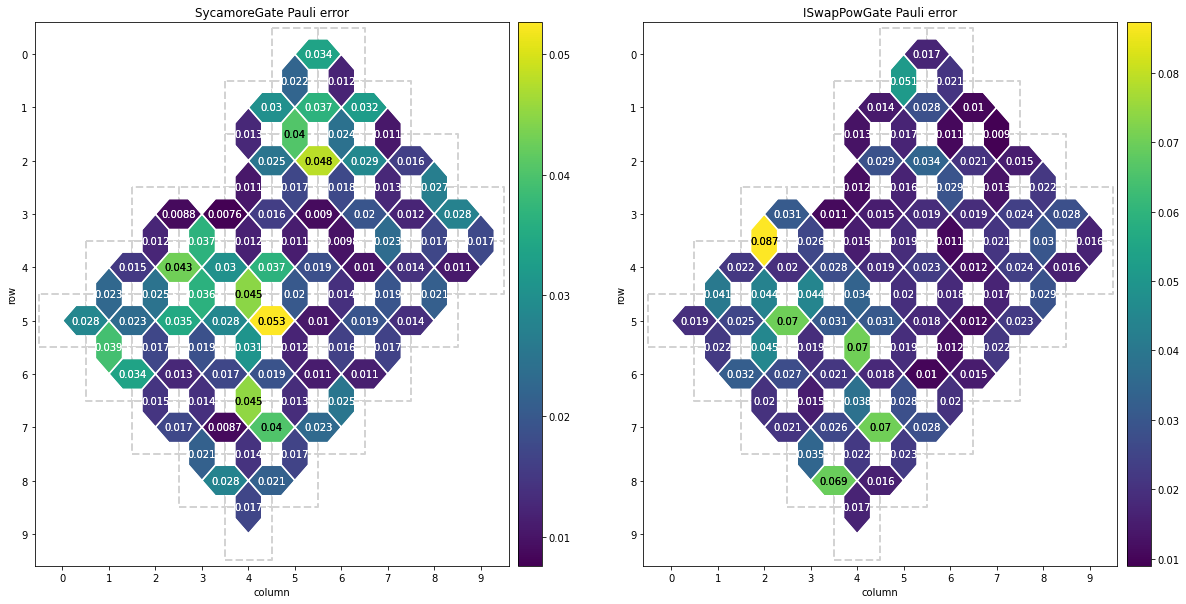

In [8]:
two_qubit_gates = noise_props.two_qubit_gates()
print(f"Two qubit error data: gate_pauli_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: pauli_error
        for op_id, pauli_error in noise_props.gate_pauli_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        ax.set_title(f"{gate.__name__} Pauli error")
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)

fig.show()


One qubit error data: readout_errors


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_91405/2468238959.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


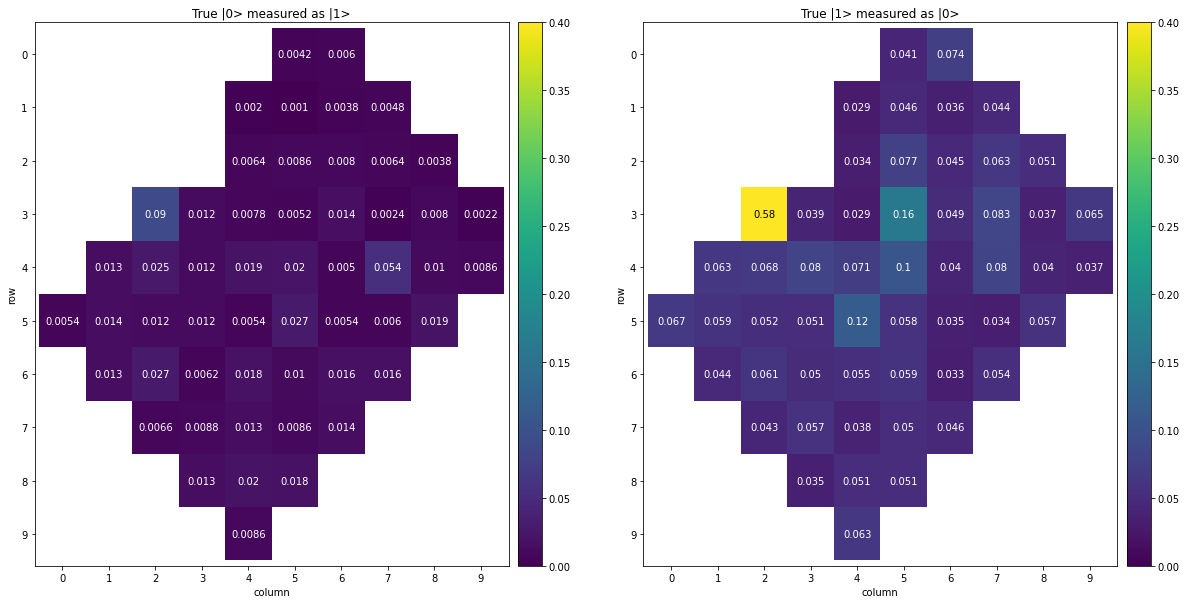

In [9]:
print(f"One qubit error data: readout_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, ax, title in zip(
    range(2), axes.flat, ["True |0> measured as |1>", "True |1> measured as |0>"]
):
    measures = {
        qubit: readout_error[i] for qubit, readout_error in noise_props.readout_errors.items()
    }
    ax.set_title(title)
    _ = cirq.Heatmap(measures).plot(ax, vmax=0.4, vmin=0)
fig.show()

## Chemistry problem

In [10]:
from tangelo.algorithms.variational import VQESolver
from tangelo.molecule_library import mol_H2_sto3g
from tangelo.algorithms.variational import BuiltInAnsatze

In [11]:
vqe_solver = VQESolver({"molecule": mol_H2_sto3g, "up_then_down": True, "ansatz": BuiltInAnsatze.HEA,
                        "qubit_mapping": "scbk", "ansatz_options": {"n_layers": 1, "rot_type": "real"}})
vqe_solver.build()
print(vqe_solver.simulate())

-1.1372700355720462


To use the weber device qubits (3, 6) and (4, 6). We can obtain the expectation value as normal.

In [12]:
sim_weber = Simulator(Cirq_QVM, n_shots=10000, noise_model='weber',
                      qubits_to_use=[cirq.GridQubit(3, 6), cirq.GridQubit(4, 6)])
sim_weber.get_expectation_value(vqe_solver.qubit_hamiltonian, vqe_solver.optimal_circuit)

-1.0445577786501838

Things to note. 
1. The qubits in the circuit must all be used and be in the `range(n_qubits)`. This can be done with the function `circuit.trim_qubits()`.
2. You can reorder as you like with `qubits_to_list=[25,24,16,19]`
3. The length of qubits_to_list must equal the number of qubits and the connectivity much match the circuit.

## Test with "rainbow"

In [34]:
processor_id = "rainbow"
cal = cirq_google.engine.load_median_device_calibration(processor_id)
noise_props = cirq_google.noise_properties_from_calibration(cal)
sim_rainbow = Simulator(Cirq_QVM, n_shots=100, noise_model=processor_id,
                       qubits_to_use=[])
print(sim_rainbow.sim_device)

                  (3, 2)
                  │
                  │
         (4, 1)───(4, 2)───(4, 3)
         │        │        │
         │        │        │
(5, 0)───(5, 1)───(5, 2)───(5, 3)───(5, 4)
         │        │        │        │
         │        │        │        │
         (6, 1)───(6, 2)───(6, 3)───(6, 4)───(6, 5)
                  │        │        │        │
                  │        │        │        │
                  (7, 2)───(7, 3)───(7, 4)───(7, 5)───(7, 6)
                           │        │        │
                           │        │        │
                           (8, 3)───(8, 4)───(8, 5)
                                    │
                                    │
                                    (9, 4)


Two qubit error data: gate_pauli_errors


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_91405/4192391102.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


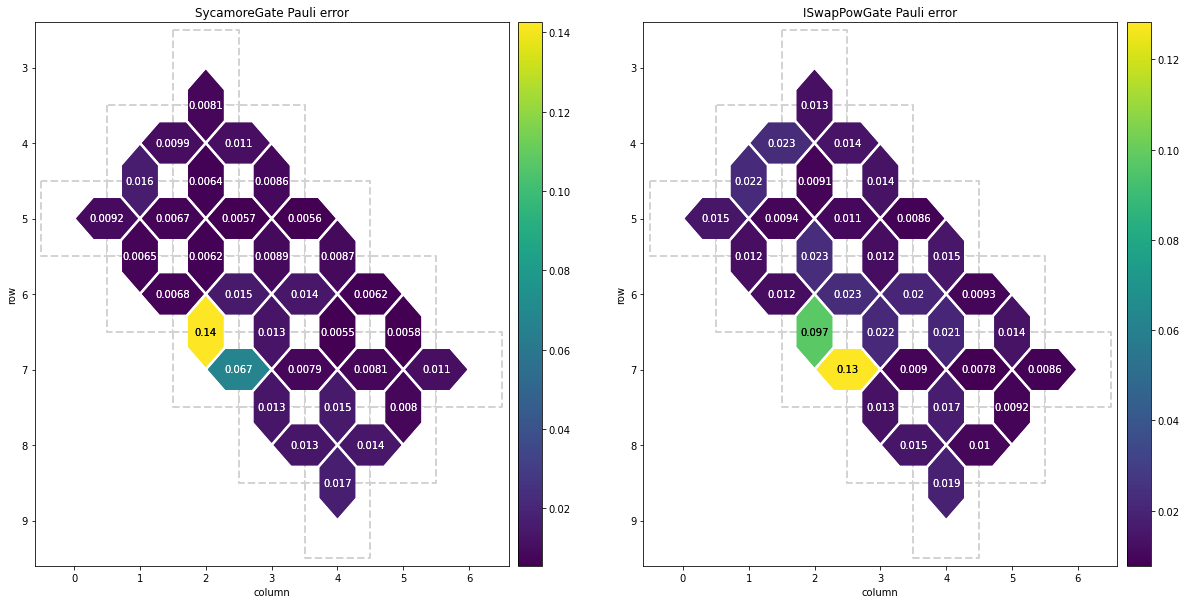

In [35]:
two_qubit_gates = noise_props.two_qubit_gates()
print(f"Two qubit error data: gate_pauli_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = iter(axes)
for gate in two_qubit_gates:
    measures = {
        op_id.qubits: pauli_error
        for op_id, pauli_error in noise_props.gate_pauli_errors.items()
        if op_id.gate_type == gate
    }
    if measures:
        ax = next(axes)
        ax.set_title(f"{gate.__name__} Pauli error")
        _ = cirq.TwoQubitInteractionHeatmap(measures).plot(ax)

fig.show()

One qubit error data: gate_pauli_errors
Supported Gates: {<class 'cirq.ops.common_gates.ZPowGate'>, <class 'cirq.ops.phased_x_z_gate.PhasedXZGate'>, <class 'cirq.ops.common_channels.ResetChannel'>, <class 'cirq.ops.measurement_gate.MeasurementGate'>}


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_91405/4195693688.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


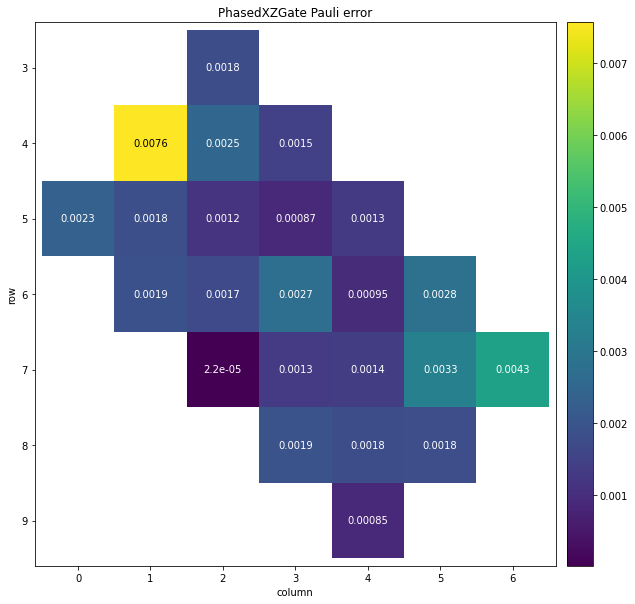

In [36]:
print(f"One qubit error data: gate_pauli_errors")
print(f"Supported Gates: {noise_props.single_qubit_gates()}")
fig, ax = plt.subplots(figsize=(10, 10))
gate = cirq.PhasedXZGate
measures = {
    op_id.qubits: pauli_error
    for op_id, pauli_error in noise_props.gate_pauli_errors.items()
    if op_id.gate_type == gate
}
ax.set_title(f"{gate.__name__} Pauli error")
_ = cirq.Heatmap(measures).plot(ax)
fig.show()

One qubit error data: readout_errors


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_91405/2468238959.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


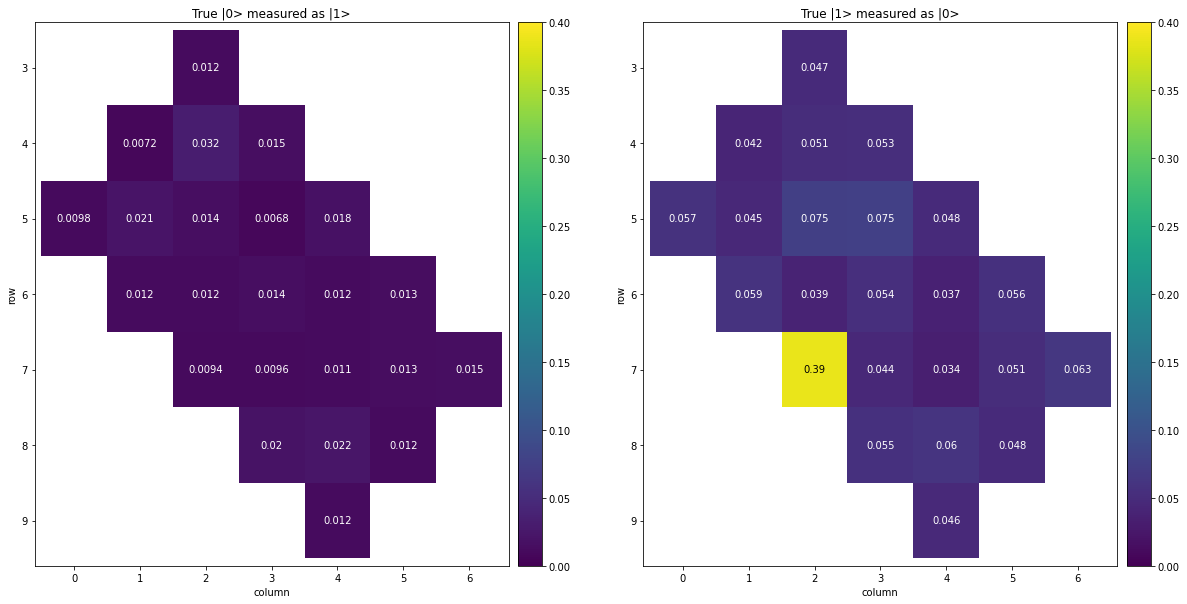

In [38]:
print(f"One qubit error data: readout_errors")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i, ax, title in zip(
    range(2), axes.flat, ["True |0> measured as |1>", "True |1> measured as |0>"]
):
    measures = {
        qubit: readout_error[i] for qubit, readout_error in noise_props.readout_errors.items()
    }
    ax.set_title(title)
    _ = cirq.Heatmap(measures).plot(ax, vmax=0.4, vmin=0)
fig.show()

In [37]:
sim_rainbow = Simulator(Cirq_QVM, n_shots=10000, noise_model=processor_id,
                      qubits_to_use=[cirq.GridQubit(5, 3), cirq.GridQubit(5, 4)])
sim_rainbow.get_expectation_value(vqe_solver.qubit_hamiltonian, vqe_solver.optimal_circuit)

-1.014731782704166